In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import Callable, Tuple, Union, List

Gaussian Mixture pdf function:
$$f(x) = \sum_{i=1}^{k} w_i \cdot \mathcal{N}(x; \mu_i, \sigma_i^2)$$

The gradient of the log-pdf of a 1D Gaussian mixture model is:


$$\nabla_x \log p(x) = \frac{1}{p(x)} \sum_{k=1}^K \gamma_k(x) \cdot \left(-\frac{x - \mu_k}{\sigma_k^2}\right)$$

where

$$\gamma_k(x) = w_k \, \mathcal{N}(x; \mu_k, \sigma_k^2)$$

is the unnormalized component density of the \(k\)-th Gaussian, and

$$p(x) = \sum_{j=1}^K \gamma_j(x)$$

is the total mixture density.





In [2]:
weights = [0.3, 0.7]
gaussians = [(3,1.5), (-1,1)]

def gaussian_mixture_pdf(
   x: Union[float, np.ndarray], 
   weights: List[float], 
   gaussians: List[Tuple[float, float]]
) -> Union[float, np.ndarray]:
    """
    Compute the probability density function of a Gaussian mixture model.

    Parameters
    ----------
    x : Union[float, np.ndarray]
        Input values where the PDF is evaluated. Can be a scalar or array.
    weights : List[float]
        Mixture weights for each Gaussian component. Must sum to 1.
    gaussians : List[Tuple[float, float]]
        List of (mean, std_dev) tuples defining each Gaussian component.
        Each tuple contains (loc, scale) parameters for scipy.stats.norm.

    Returns
    -------
    Union[float, np.ndarray]
        PDF values at input points x. Returns scalar if x is scalar,
        otherwise returns array of same shape as x.
    """
    x_array = np.atleast_1d(x)
    
    pdf = np.zeros(len(x_array))
    for w, (loc, scale) in zip(weights, gaussians):
        pdf += w * st.norm.pdf(x_array, loc=loc, scale=scale)
    
    return pdf[0] if np.isscalar(x) else pdf


def log_guassian_pdf_x_derv(x: np.ndarray, loc: float, scale: float) -> np.ndarray:
    return - (x - loc)/(scale**2)


def log_gaussian_mixture_pdf_x_derv(
   x: Union[float, np.ndarray], 
   weights: List[float], 
   gaussians: List[Tuple[float, float]]
) -> Union[float, np.ndarray]:
    x_array = np.atleast_1d(x)

    derv = np.zeros(len(x_array))
    total_pdf = np.zeros(len(x_array))
    for w, (loc, scale) in zip(weights, gaussians):
        pdf = w * st.norm.pdf(x_array, loc=loc, scale=scale)
        total_pdf += pdf
        derv += pdf * log_guassian_pdf_x_derv(x_array, loc, scale)

    derv /= total_pdf

    return derv


In [3]:
n_samples = 10_000
step_size = 0.1
n_steps = 100
init_samples = lambda n: np.random.uniform(-2, 3, n)
target_pdf_x_derv = (
    lambda x: log_gaussian_mixture_pdf_x_derv(x, weights, gaussians)
)

In [ ]:
def langevin_sampling(
    n_samples: int,
    n_steps: int,
    step_size: float,
    init_sampler: Callable,
    target_pdf_x_derv: Callable,
    save_per_step: bool = False,
    seed: int = None,
) -> Union[np.ndarray, Tuple[np.ndarray, List[np.ndarray]]]:
    """
    Performs Langevin sampling.

    Args:
        n_samples: Number of samples.
        n_steps: Number of Langevin steps.
        step_size: Step size (epsilon).
        init_sampler: Function to initialize samples.
        target_pdf_x_derv: Function returning gradient of log-pdf wrt samples.
        save_per_step: Whether to save samples at each step.
        seed: Optional random seed.

    Returns:
        If save_per_step: (final_samples, list_of_samples_per_step)
        Else: final_samples
    """
    if seed is not None:
        np.random.seed(seed)

    samples = init_sampler(n_samples)
    samples_per_step = [] if save_per_step else None

    if save_per_step:
        samples_per_step.append(np.copy(samples))

    for _ in range(n_steps):
        grad = target_pdf_x_derv(samples)
        noise = np.random.normal(0, np.sqrt(step_size), n_samples)
        samples += 0.5 * step_size * grad + noise
        if save_per_step:
            samples_per_step.append(np.copy(samples))

    if save_per_step:
        return samples, samples_per_step
    else:
        return samples


In [5]:
samples, samples_evolution = langevin_sampling(n_samples, n_steps, step_size, init_samples, target_pdf_x_derv, True)

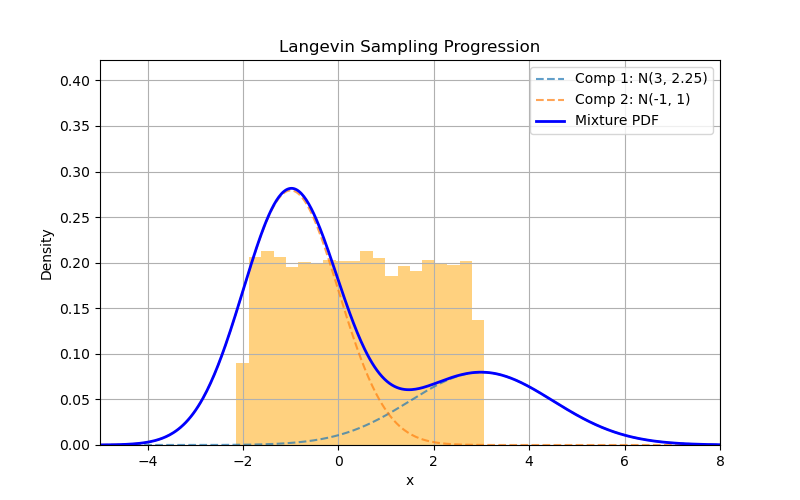

In [6]:
%matplotlib ipympl
x_vals = np.linspace(-5, 8, 500)

# PDF components and mixture
component_pdfs = [w * st.norm.pdf(x_vals, loc=mu, scale=sigma)
                  for (mu, sigma), w in zip(gaussians, weights)]
mixture_pdf = np.sum(component_pdfs, axis=0)


fig, ax = plt.subplots(figsize=(8, 5))

# Static: components and mixture
for i, pdf in enumerate(component_pdfs):
    mu, sigma = gaussians[i]
    ax.plot(x_vals, pdf, '--', alpha=0.7, label=f'Comp {i+1}: N({mu}, {sigma**2})')
ax.plot(x_vals, mixture_pdf, 'b-', label='Mixture PDF', linewidth=2)

# Initial histogram from step 0
bars = ax.hist(samples_evolution[0], bins=50, range=(-5, 8), density=True,
               alpha=0.5, color='orange')[2]

ax.set_xlim(-5, 8)
ax.set_ylim(0, max(mixture_pdf) * 1.5)
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Langevin Sampling Progression')
ax.legend(loc='upper right')
ax.grid(True)


def animate(i):
    counts, _ = np.histogram(samples_evolution[i], bins=50, range=(-5, 8), density=True)
    for count, bar in zip(counts, bars):
        bar.set_height(count)
    ax.set_title(f'Langevin Sampling Step {i}/{len(samples_evolution) - 1}')
    return bars

ani = FuncAnimation(fig, animate, frames=len(samples_evolution), interval=200)
plt.show()

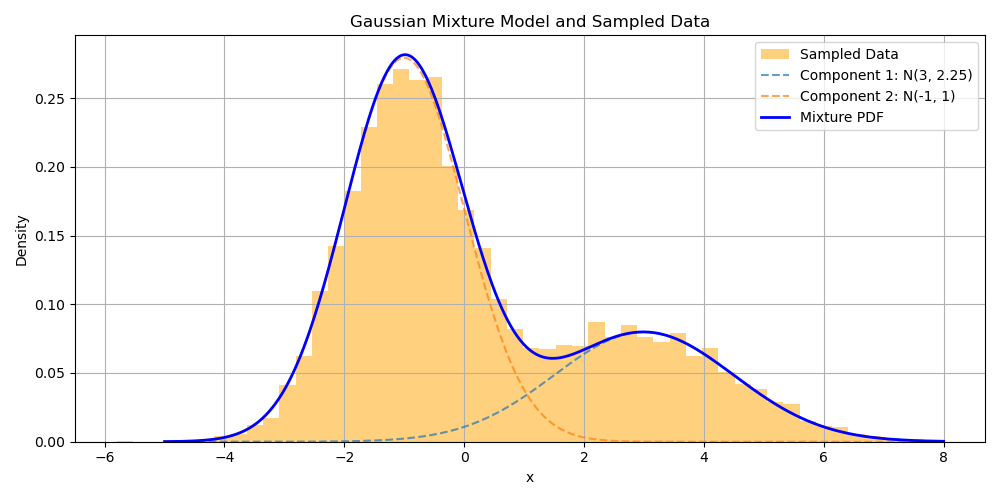

In [7]:
x_vals = np.linspace(-5, 8, 500)

# Compute individual Gaussian pdfs
component_pdfs = [w * st.norm.pdf(x_vals, loc=mu, scale=sigma) 
                  for (mu, sigma), w in zip(gaussians, weights)]

# Total mixture pdf
mixture_pdf = np.sum(component_pdfs, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Sampled Data', color='orange')

# Plot each Gaussian component
for i, pdf in enumerate(component_pdfs):
    mu, sigma = gaussians[i]
    plt.plot(x_vals, pdf, '--', alpha=0.7, label=f'Component {i+1}: N({mu}, {sigma**2})')

# Plot total mixture
plt.plot(x_vals, mixture_pdf, 'b-', label='Mixture PDF', linewidth=2)

plt.title('Gaussian Mixture Model and Sampled Data')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()